# <center>1. Introduction </center>


### This example demonstrates the following main functionalities of portpy.photon module:


1. Accessing the curated portpy data
    (DataExplorer class)

2. Creating a simple IMRT plan through integration with [CVXPy](https://www.cvxpy.org/) package
    (Plan class, Optimization class)

3. Visualising the plan (e.g., dose distribution, fluence, DVH)
   (Visualization class)

4. Evaluating the plan (e.g., max/mean/DVH points, established clinical metrics)
    (Evaluation class)

5. Saving the plan and solution for future uses
    (Utils)

6. Enhanced plan visualization through integration with [3D-Slicer](https://www.slicer.org/) package
    (Visualization class)


### 1) Accessing the portpy data (DataExplorer class)
PortPy provides researchers with a comprehensive benchmark patient dataset derived from an FDA-approved [Eclipse](https://www.varian.com/products/radiotherapy/treatment-planning/eclipse) commercial treatment planning system via its API. This dataset includes all the necessary components for optimizing various machine settings such as beam angles, aperture shapes, and leaf movements. In addition to the CT images and delineated contours, the dataset includes:
 1. **Dose Influence Matrix:** The dose contribution of each beamlet to each voxel, 
 2. **Beamlets/Voxels Details:** Detailed information about the position and size of beamlets/voxels,
 3. **Expert-Selected Benchmark Beams:** An expert clinical physicist has carefully selected benchmark beams, providing reference beams for comparison and benchmarking,
 4. **Benchmark IMRT Plan:** A benchmark IMRT plan generated using MSK in-house automated treatment planning system called [ECHO](https://youtu.be/895M6j5KjPs). This plan serves as a benchmark for evaluating new treatment planning algorithms.
 
 To start using this resource, users are required to download the latest version of the dataset, which can be found [here](https://drive.google.com/drive/folders/1nA1oHEhlmh2Hk8an9e0Oi0ye6LRPREit). Then, the dataset can be accessed as demonstrated below.



In [6]:
import sys
sys.path.append('..')

In [7]:
# If you're running PortPy for the first time, you need to install the requirements 
# !pip install -r ..\requirements.txt

In [8]:
import portpy.photon as pp
import numpy as np
import os

In [10]:
# specify the patient data location.
data_dir = r'../data'
# Use PortPy DataExplorer class to explore PortPy data
data = pp.DataExplorer(data_dir=data_dir)
# display the existing patients 
data.display_list_of_patients()
# the following table shows the collection of benchmark patients with some releavant information

,patient_id,disease_site,ptv_vol_cc,num_beams
0,Lung_Patient_10,Lung,308.809,72
1,Lung_Patient_2,Lung,737.229,72
2,Lung_Patient_3,Lung,160.546,72
3,Lung_Patient_4,Lung,312.623,72
4,Lung_Patient_5,Lung,323.696,72
5,Lung_Patient_6,Lung,87.487,72
6,Lung_Patient_7,Lung,177.273,72
7,Lung_Patient_8,Lung,614.168,72
8,Lung_Patient_9,Lung,173.781,72
9,Lung_Phantom_Patient_1,Lung,43.902,72


In [12]:
# pick a patient from the existing patient list to get detailed info (e.g., beam angles, structures).
data.patient_id = 'Lung_Phantom_Patient_1'
# display the data of the patient 
# user can get the results back in the panda dataframe format by using the arguments 'return_beams_df' and 'return_structs_df'
beams_df, structs_df = data.display_patient_metadata(return_beams_df=True, return_structs_df=True)
beams_df.head()
# the following table shows the beams for which the data has been extracted for the specified patient

,ID,gantry_angle,collimator_angle,couch_angle,beam_modality,energy_MV,influence_matrix(sparse/full),iso_center,MLC_name,machine_name
0,0,0,0,0,Photon,6,Both,"{'x_mm': 79.47996, 'y_mm': 134.0219, 'z_mm': 3...",VARIAN MILLENIUM 120,VARIAN TRUE BEAM
1,1,5,0,0,Photon,6,Both,"{'x_mm': 79.47996, 'y_mm': 134.0219, 'z_mm': 3...",VARIAN MILLENIUM 120,VARIAN TRUE BEAM
2,2,10,0,0,Photon,6,Both,"{'x_mm': 79.47996, 'y_mm': 134.0219, 'z_mm': 3...",VARIAN MILLENIUM 120,VARIAN TRUE BEAM
3,3,15,0,0,Photon,6,Both,"{'x_mm': 79.47996, 'y_mm': 134.0219, 'z_mm': 3...",VARIAN MILLENIUM 120,VARIAN TRUE BEAM
4,4,20,0,0,Photon,6,Both,"{'x_mm': 79.47996, 'y_mm': 134.0219, 'z_mm': 3...",VARIAN MILLENIUM 120,VARIAN TRUE BEAM


In [13]:
structs_df.head()
# the following table shows the list of structures for the specified patient

,name,volume_cc
0,GTV,27.629362
1,LUNGS_NOT_GTV,2983.244630
2,PTV,43.901787
3,CORD,5.307685
4,HEART,841.405457


In [14]:
# Load ct, structure set, beams for the above patient using CT, Structures, and Beams classes
ct = pp.CT(data)
structs = pp.Structures(data)
beams = pp.Beams(data)
# By default, PortPy uses the beams selected by an expert planner, which are included as part of the dataset. 
# However, you can pass your own selection of beams as an argument. For instance, to use beams with the ids 0, 10, 20, 30, 40
# you would construct your Beams object like this: beams = pp.Beams(data, beam_ids=[0,10,20,30,40]).

 #### Clinical Protocols
In order to create an IMRT plan, we first need to specify a protocol which includes the disease site, the prescribed dose for the PTV, the number of fractions, and the radiation dose thresholds for OARs. These information are stored in .json files which can be found in a directory named "config_files". An example of such a file is 'Lung_2Gy_30Fx.json'. Here's how you can load these files:
 

In [15]:
protocol_name = 'Lung_2Gy_30Fx'
clinical_criteria = pp.ClinicalCriteria(data, protocol_name=protocol_name)

#### Optimization Problem Formulation
The next step is to fromulate an optimization problem with an objective function measuring various plan quality metrics, along with a set of non-negotiable constraints often encapsulated as max/mean/Dose-Volume Histogram (DVH) constraints outlined in the clinical protocol. Our default problem formulation is as follows:

$
   \mbox{Minimize} \quad  w_o||A^{PTV}\mathbf{x}-pres||^2_{+} + w_u||A^{PTV}\mathbf{x}-pres||^2_{-} + \sum_{s\in OARs}w_{s}  ||A^s \mathbf{x}||^2 + w_{sm}(smoothness \space objective)  
$

$
\mbox{subject to}
$

$
\quad maximum(A_s\mathbf{x}) \leq {d_s}^{max}
$

$
\quad mean(A_s\mathbf{x}) \leq {d_s}^{mean}
$

$
\quad \mathbf{x} \geq 0
$

Here, $\mathbf{A}$ represents the dose influence matrix, parameterizing the dose delivered to each voxel from each beamlet. $\mathbf{x}$ refers to the optimal beamlet intensities (also known as beam profiles or fluence map), while $pres$ stands for the prescribed dose to the PTV. The operators $||.||_{+}$ and $||.||_{-}$ represent the positive and negative parts of the input vector respectively. 
The first term in the optimization problem penalizes the *PTV-overdose*, the deviation of the dose delivered to PTV ($A^{PTV}\mathbf{x}$) from the prescribed dose, and the second term penalizes *PTV-underdose*. The third term seeks to minimize the OAR doses, and the final term encourages fluence map smoothness by penalizing deviation of each beamlet intensity from its neighbors:

$
smoothness \space objective = w_r\sum_{b\in{B}}\sum_{i\in{I_b}}(\mathbf{x}_i - \mathbf{x}_{R_i})^2 + w_l\sum_{b\in{B}}\sum_{i\in{I_b}}(\mathbf{x}_i - \mathbf{x}_{L_i})^2
$

Here, $R_i$ and $L_i$ denote the right and lower neighbor of beamlet i respectively, $b$ refers to the beam number, and $I_b$ refers to the beamlet indices of beam $b$. The first term in the smoothness objective encourages smoothness in the leaf travel direction (often referred to as X-direction), weighted by $w_r$. The second term promotes smoothness in the Y-direction (perpendicular to the X-direction), weighted by $w_l$. Typically, $w_r$ is set to 0.6 and $w_l$ to 0.4, due to the greater importance of smoothness in the leaf travel direction. 


The above optimization problem, however, does not account for radiation dose delivered to healthy tissues that aren't part of any delineated structure. This is often resolved by creating a series of artificial 'donut-shaped' structures, or 'Rinds' (also known as 'Shells' or 'Rings') around the PTV. These are considered optimization structures and treated as OARs within the optimization problem.


Considering the multi-criteria nature of radiation treatment planning and the balancing act between PTV coverage and OAR sparing, the objective function in the optimization problem includes several hyperparameters (i.e., $w_o$, $w_u$, $w_s$, $w_{sm}$) that require fine-tuning per patient. Another set of hyperparameters relates to optimization structures (e.g., Rind structure sizes and constraints). Based on our experiments, it's feasible to create a reasonable plan for many patients following a specific clinical protocol using a fixed set of hyperparameters. While such a plan may not be clinically optimal, it is often sufficient for many research purposes. As such, we've stored a set of hyperparameters for each clinical protocol in .json files located in the 'config_files' directory (e.g., 'optimization_params_Lung_2Gy_30Fx.json'). 


##### Note:  
Overcoming the challenge of hyperparameter tuning has been an active research focus for several years, with many advanced techniques being developed. AI-based planning, in particular, has been gaining considerable traction recently (Example-10 illustrates how to predict 3D dose and convert it to a deliverable plan). In our group, we have developed and clinically implemented an automated planning system called [ECHO](https://youtu.be/895M6j5KjPs), which leverages hierarchical optimization (also known as prioritized optimization). We plan to release the code for this in the near future. 

In [16]:
protocol_name = 'Lung_2Gy_30Fx'
# Loading hyper-parameter values for optimization problem
opt_params = data.load_config_opt_params(protocol_name=protocol_name)
# Creating optimization structures (i.e., Rinds) 
structs.create_opt_structures(opt_params=opt_params, clinical_criteria=clinical_criteria)
# Loading influence matrix
inf_matrix = pp.InfluenceMatrix(ct=ct, structs=structs, beams=beams)

creating rinds.. This step may take some time due to dilation
rinds created!!
Creating BEV..
Loading sparse influence matrix...
Done


#### Truncated influence matrix
The dose influence matrix plays a pivotal role in the optimization process, but it can also pose significant computational challenges when solving optimization problems. The original matrix is dense and handling it can be computationally demanding. For this reason, we opt to load a truncated version of the matrix by default. However, this truncation introduces discrepancies between the optimized dose and the final dose. Please refer to the PortPy tutorial on [Eclipse integration](https://github.com/PortPy-Project/PortPy/blob/master/examples/eclipse_integration.ipynb) for guidance on how to address this issue and also how to import the plan into Eclipse for final evaluation.

If computational issues persist, you could consider additional measures. For example, you could down-sample the voxels/beamlets, as demonstrated in [down_sampling](https://github.com/PortPy-Project/PortPy/blob/master/examples/advanced_tutorials/down_sampling.ipynb) example, or further sparsify the influence matrix, as shown in [inf_matrix_sparsification](https://github.com/PortPy-Project/PortPy/blob/master/examples/advanced_tutorials/inf_matrix_sparsification.ipynb) example.

### 2) Creating a simple IMRT plan using CVXPy (Plan class, Optimization class)
We use [CVXPy](https://www.cvxpy.org/), a Python-embedded modeling language, to solve the resulting optimization problems. CVXPy offers a high-level programming interface for easy prototyping and seamless access to several open-source (e.g., ECOS, OSQP, SCS) and commercial optimization engines (e.g., MOSEK, GUROBI, CPLEX). Most commercial engines offer free licenses for research and academic purposes, however, it is up to users to secure these licenses.

In our experiments, we found the commercial solver MOSEK to be highly efficient in solving the IMRT optimization problems. You can obtain the MOSEK license file by applying using an .edu account [here](https://www.mosek.com/products/academic-licenses/). The license file should be placed in the directory C:\Users\username\mosek. If a license is not available, you may try open-source or free solvers like SCS or ECOS. Please refer to the CVXPy documentation for more information about its various solvers.


In [18]:
# create a plan using ct, structures, beams and influence matrix, and clinical criteria
my_plan = pp.Plan(ct = ct, structs = structs, beams = beams, inf_matrix = inf_matrix, clinical_criteria=clinical_criteria)

# create cvxpy problem using the clinical criteria and optimization parameters
opt = pp.Optimization(my_plan, opt_params=opt_params, clinical_criteria=clinical_criteria)
opt.create_cvxpy_problem()
# solve the cvxpy problem using Mosek
sol = opt.solve(solver='MOSEK', verbose=False)

Objective Start
Objective done
Constraints Start
Structure ESOPHAGUS not available!
Structure ESOPHAGUS not available!
Constraints done


### 3) Visualizing the plan (Visualization class)

<Axes: xlabel='x-axis (beamlets column)', ylabel='y-axis (beamlets row)'>

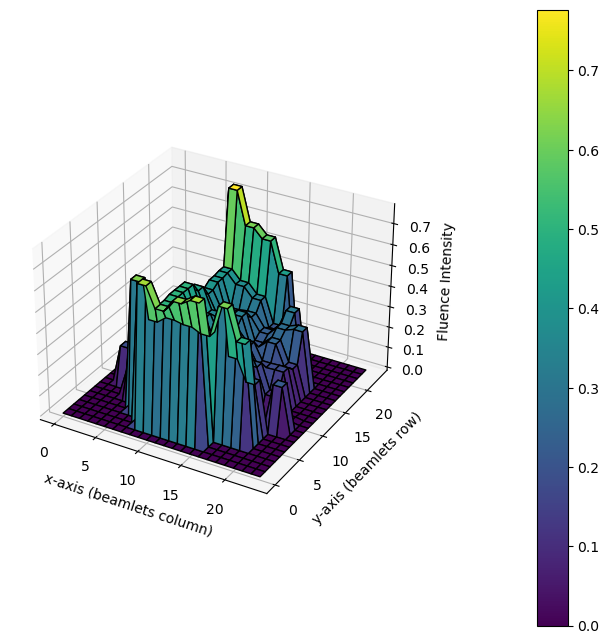

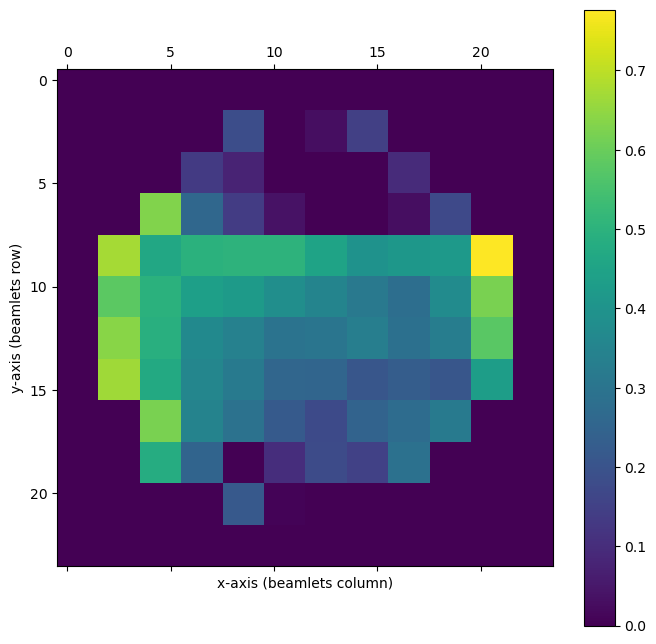

In [19]:
# plot fluence 3d and 2d for the 1st beam
pp.Visualization.plot_fluence_3d(sol=sol, beam_id=my_plan.beams.get_all_beam_ids()[0])

pp.Visualization.plot_fluence_2d(sol=sol, beam_id=my_plan.beams.get_all_beam_ids()[0])


<Axes: title={'center': 'Lung_Phantom_Patient_1'}, xlabel='Dose (Gy)', ylabel='Volume Fraction (%)'>

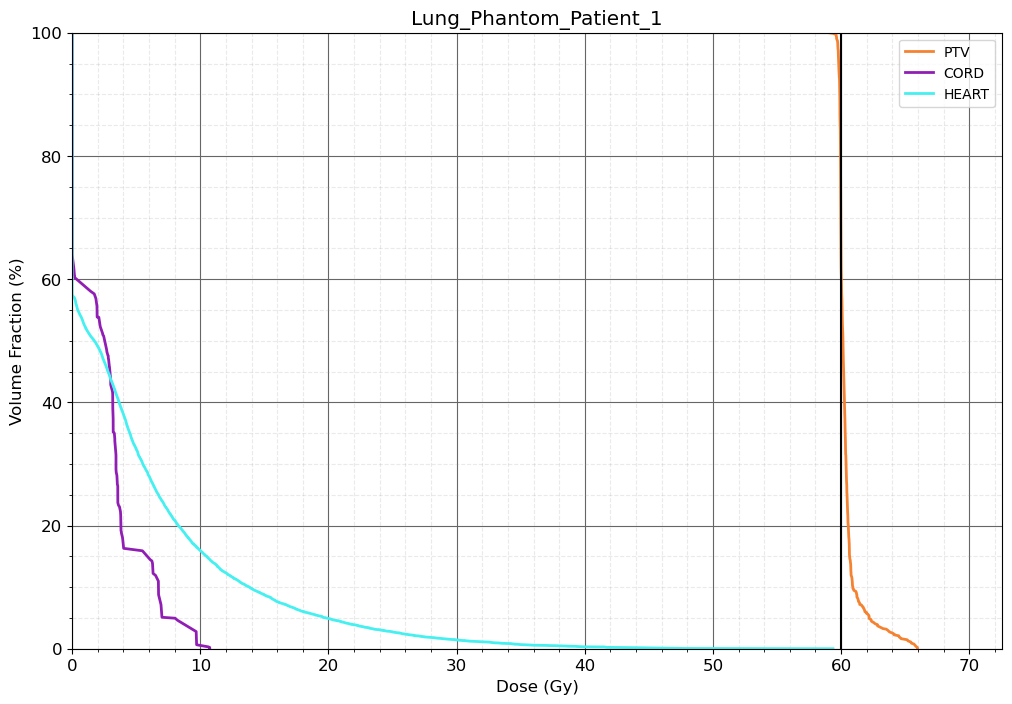

In [20]:
# plot dvh for the structures in the given list. Default dose_1d is in Gy and volume is in relative scale(%).
struct_names = ['PTV', 'ESOPHAGUS', 'HEART', 'CORD']

# plot dvh for the above structures
pp.Visualization.plot_dvh(my_plan, sol=sol, struct_names=struct_names, title=data.patient_id)


<Axes: title={'center': 'Axial View - Slice #: 60'}>

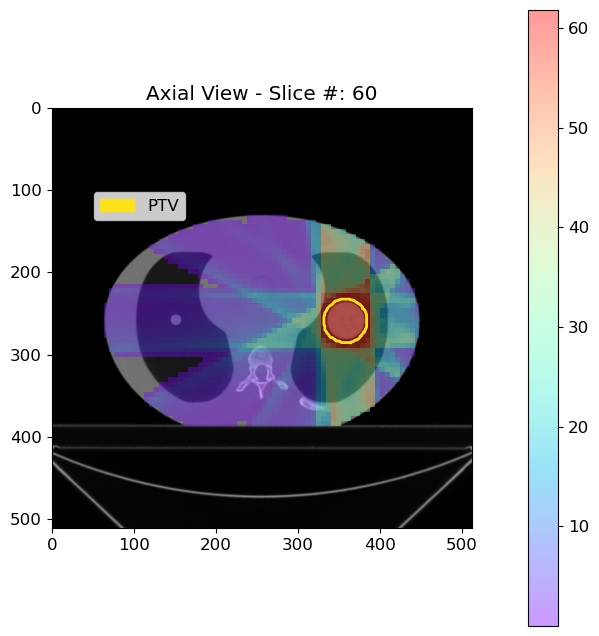

In [21]:
# plot 2d axial slice for the given solution and display the structures contours on the slice
pp.Visualization.plot_2d_slice(my_plan=my_plan, sol=sol, slice_num=60, struct_names=['PTV'])

### 4) Evaluating the plan (Evaluation class)
The Evaluation class offers a set of methods for quantifying the optimized plan. If you need to compute individual dose volume metrics, you can use methods such as *get_dose* or *get_volume*. Furthermore, the class also facilitates the assessment of the plan based on a collection of metrics, such as mean, max, and dose-volume histogram (DVH), as specified in the clinical protocol. This capability is demonstrated below


In [22]:
# visualize plan metrics and compare them against the clinical criteria
pp.Evaluation.display_clinical_criteria(my_plan, sol=sol, clinical_criteria=clinical_criteria)
# The Evaluation class also has methods to extract different DVH metrics (e.g., get_dose(sol, struct, volume_per), get_volume(sol: struct dose_value_gy)))


,name,parameters,constraints,Plan Value
0,max_dose,{'structure_name': 'GTV'},"{'limit_dose_gy': 69, 'goal_dose_gy': 66}",65.960515
1,max_dose,{'structure_name': 'PTV'},"{'limit_dose_gy': 69, 'goal_dose_gy': 66}",65.960515
2,max_dose,{'structure_name': 'HEART'},{'limit_dose_gy': 66},59.355868
3,mean_dose,{'structure_name': 'HEART'},"{'limit_dose_gy': 27, 'goal_dose_gy': 20}",4.756941
4,dose_volume_V,"{'structure_name': 'HEART', 'dose_gy': 30}",{'limit_volume_perc': 50},1.433085
5,dose_volume_V,"{'structure_name': 'HEART', 'dose_gy': 30}",{'goal_volume_perc': 48},1.433085
6,max_dose,{'structure_name': 'LUNG_L'},{'limit_dose_gy': 66},65.960515
7,max_dose,{'structure_name': 'LUNG_R'},{'limit_dose_gy': 66},25.475012
8,max_dose,{'structure_name': 'CORD'},"{'limit_dose_gy': 50, 'goal_dose_gy': 48}",10.729729
9,max_dose,{'structure_name': 'SKIN'},{'limit_dose_gy': 60},50.963999


### 5) Saving and loading the plan for future use (utils)


In [13]:
# Comment/Uncomment these lines to save and load the pickle file for plans and optimal solution from the directory
pp.save_plan(my_plan, plan_name='my_plan_phantom.pkl', path=os.path.join(r'C:\temp', data.patient_id))
pp.save_optimal_sol(sol, sol_name='sol_phantom.pkl', path=os.path.join(r'C:\temp', data.patient_id))
# my_plan = pp.load_plan(plan_name='my_plan_phantom.pkl', path=os.path.join(r'C:\temp', data.patient_id))
# sol = pp.load_optimal_sol(sol_name='sol_phantom.pkl', path=os.path.join(r'C:\temp', data.patient_id))

### 6) Advanced visualization with 3D-Slicer (Visualization class)
Beyond the basic visualizations available in PortPy, we also offer enhanced visualization capabilities through integration with [3D-Slicer](https://www.slicer.org/). If you're working with Jupyter Notebook, this integration is seamless and only necessitates some adjustments in the Jupyter Notebook Kernels (please refer to Example [3d_slicer_integration](https://github.com/PortPy-Project/PortPy/blob/master/examples/3d_slicer_integration.ipynb) for details).

However, if you're utilizing a Python IDE such as PyCharm or Visual Studio Code, an additional step is required. Specifically, the data (ct, 3D dose, structures) must first be saved to a hard drive as images in nrrd formats, after which 3D-Slicer can be invoked, using the location of the saved data as an argument. Here are the necessary two lines of code to achieve this:
 



In [14]:
# Note: This requires downloading and installing 3d slicer

pp.save_nrrd(my_plan, sol=sol, data_dir=os.path.join(r'C:\temp', data.patient_id))
pp.Visualization.view_in_slicer(my_plan, slicer_path=r'C:\ProgramData\NA-MIC\Slicer 5.2.1\Slicer.exe',
                                data_dir=os.path.join(r'C:\temp', data.patient_id))
print('Done!')


Done
Done!
